In [1]:
%load_ext autoreload
%autoreload 2
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import urllib3
urllib3.disable_warnings()
from datetime import date

# Local imports
from hat.api_call import *
from hat.utils.hydropower_potential import *
from hat.utils.PyGeoTools.geolocation import *

/Users/galljf/OneDrive - Idaho National Laboratory/code/hat/hat/utils/hydropower_potential.py:172: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
  self.effi_cal = (1-1.25((peak_eff_flow - self.flow_range)/peak_eff_flow)**1.13)*peak_eff


In [2]:
query_df = pd.read_csv(f'data/query_2021-06-24.csv')
input_df = pd.read_csv('combined_hydro_stream_gauge_full2.csv')

query_df.drop_duplicates(subset= ['site_id'],inplace=True)
query_df.info

query_df.head()

,Unnamed: 0,Unnamed: 0.1,start,end,lat,lon,name,site_id,json_filename,csv_filename,...,mean_capacity_factor_2013_10,stdev_capacity_factor_2013_10,mean_power_mw_2013_10,mean_capacity_factor_2013_11,stdev_capacity_factor_2013_11,mean_power_mw_2013_11,mean_capacity_factor_2013_12,stdev_capacity_factor_2013_12,mean_power_mw_2013_12,post_csv_filename
0,0,0,2000-01-01,2020-12-31,40.147715,-105.865879,GRANBY,9019500,data/2000_2020_npd/raw/npd_09019500_2000-01-01...,data/2000_2020_npd/raw/npd_09019500_2000-01-01...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/galljf/OneDrive - Idaho National Labora...
1,1,1,2000-01-01,2020-12-31,36.466670,-91.530000,MAMMOTH SPRINGS DAM 3,7069220,data/2000_2020_npd/raw/npd_07069220_2000-01-01...,data/2000_2020_npd/raw/npd_07069220_2000-01-01...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2000-01-01,2020-12-31,35.394714,-106.547531,JEMEZ CANYON DAM,8328950,data/2000_2020_npd/raw/npd_08328950_2000-01-01...,data/2000_2020_npd/raw/npd_08328950_2000-01-01...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/galljf/OneDrive - Idaho National Labora...
3,3,3,2000-01-01,2020-12-31,41.475038,-79.445464,TIONESTA DAM,3020000,data/2000_2020_npd/raw/npd_03020000_2000-01-01...,data/2000_2020_npd/raw/npd_03020000_2000-01-01...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/galljf/OneDrive - Idaho National Labora...
4,4,4,2000-01-01,2020-12-31,34.398667,-87.987939,Bear Creek,3592000,data/2000_2020_npd/raw/npd_03592000_2000-01-01...,data/2000_2020_npd/raw/npd_03592000_2000-01-01...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/galljf/OneDrive - Idaho National Labora...


In [16]:
month_keys = ['01','02','03','04','05','06','07','08','09','10','11','12']
years = [str(x) for x in range(2012,2013)]

nan_values_columns = ['site_id']

for year in years:
    nan_values_columns.append(year)

for year in years:
    for month in month_keys:
        nan_values_columns.append(f'{year}_{month}')

In [17]:
nan_df = pd.DataFrame(columns=nan_values_columns)
nan_df

,site_id,2012,2012_01,2012_02,2012_03,2012_04,2012_05,2012_06,2012_07,2012_08,2012_09,2012_10,2012_11,2012_12


In [18]:
import sys
for idx, sg in query_df.iterrows():
    
    try:
        print(f"{idx}. Reading from {sg['site_id']}: {sg['post_csv_filename']}")
        tmp_df = pd.read_csv(sg['post_csv_filename'])

        if 'Streamflow, ft&#179;/s' in tmp_df.columns:
            tmp_df.rename(columns={'Streamflow, ft&#179;/s':'discharge(cfs)'}, inplace = True)

        tmp_df['dateTime'] = pd.to_datetime(tmp_df['dateTime'], utc=True)   
        tmp_df.set_index('dateTime',inplace=True)

        # Resample the timeseries to 1h
        #flow_info_temp = clean_data(tmp_df)
        #flow_info_temp_hourly = flow_info_temp.resample('h').mean()

        nan_df.loc[idx,'site_id'] = sg['site_id']

        for year in years:
            try:
                nan_df.loc[idx,year] = 100 * tmp_df.loc[year,'discharge(cfs)'].isnull().sum()/tmp_df.loc[year,'discharge(cfs)'].shape[0]
                for month in month_keys:
                    try:
                        nan_df.loc[idx,f'{year}_{month}'] = 100 * tmp_df.loc[f'{year}-{month}','discharge(cfs)'].isnull().sum()/tmp_df.loc[f'{year}-{month}','discharge(cfs)'].shape[0]
                    except KeyError:
                        continue
            except KeyError:
                continue

        query_df.loc[idx,'missing_values_count'] = tmp_df['discharge(cfs)'].isnull().sum()
        query_df.loc[idx,'missing_values_per'] = 100 * tmp_df['discharge(cfs)'].isnull().sum()/tmp_df.shape[0]

    except FileNotFoundError:
        print(f"No data for {sg['site_id']}")
        query_df.loc[idx,'missing_values_per'] = 100
    except ValueError:
        print(f"No data for {sg['site_id']}")
        query_df.loc[idx,'missing_values_per'] = 100
    #except KeyError:

    else:
        continue

nan_df.drop_duplicates(inplace=True)
nan_df.reset_index(drop=True, inplace=True)

today = date.today()
nan_df.to_csv(f'data/2000-2020_npd_missing_values_{today}.csv')

0. Reading from 9019500: /Users/galljf/OneDrive - Idaho National Laboratory/code/hat/data/2000_2020_npd/2012/post/npd_9019500_2012.csv
1. Reading from 7069220: nan
No data for 7069220
2. Reading from 8328950: /Users/galljf/OneDrive - Idaho National Laboratory/code/hat/data/2000_2020_npd/2012/post/npd_8328950_2012.csv
3. Reading from 3020000: /Users/galljf/OneDrive - Idaho National Laboratory/code/hat/data/2000_2020_npd/2012/post/npd_3020000_2012.csv
4. Reading from 3592000: /Users/galljf/OneDrive - Idaho National Laboratory/code/hat/data/2000_2020_npd/2012/post/npd_3592000_2012.csv
5. Reading from 7227000: /Users/galljf/OneDrive - Idaho National Laboratory/code/hat/data/2000_2020_npd/2012/post/npd_7227000_2012.csv
6. Reading from 8063800: /Users/galljf/OneDrive - Idaho National Laboratory/code/hat/data/2000_2020_npd/2012/post/npd_8063800_2012.csv
7. Reading from 6670500: /Users/galljf/OneDrive - Idaho National Laboratory/code/hat/data/2000_2020_npd/2012/post/npd_6670500_2012.csv
8. Rea

In [19]:
nan_df

,site_id,2012,2012_01,2012_02,2012_03,2012_04,2012_05,2012_06,2012_07,2012_08,2012_09,2012_10,2012_11,2012_12
0,9019500,59.5628,100,100,100,30.8333,0,0,15.3226,48.3871,20.8333,99.1935,100,100
1,8328950,31.4208,100,100,13.8441,0,0,0,0,0,0,0,65.6944,100
2,3020000,1.63934,0,19.9713,0.672043,0,0,0,0,0,0,0,0,0
3,3592000,100,100,100,100,100,100,100,100,100,100,100,100,100
4,7227000,17.4863,0,0,0,0,28.2258,80,100,0.806452,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,6890900,11.7714,3.22581,0,0,0,3.22581,50,12.9032,16.129,0,16.129,3.33333,35.7527
104,3056000,0.034153,0,0,0,0,0.134409,0,0.134409,0,0,0.134409,0,0
105,5430500,4.09836,48.3871,0,0,0,0,0,0,0,0,0,0,0
106,1113895,0.853825,0,0,0,0,0,0,3.22581,0,6.66667,0,0.416667,0


In [20]:
query_df.head(3)

,Unnamed: 0,Unnamed: 0.1,start,end,lat,lon,name,site_id,json_filename,csv_filename,...,mean_power_mw_2013_10,mean_capacity_factor_2013_11,stdev_capacity_factor_2013_11,mean_power_mw_2013_11,mean_capacity_factor_2013_12,stdev_capacity_factor_2013_12,mean_power_mw_2013_12,post_csv_filename,missing_values_count,missing_values_per
0,0,0,2000-01-01,2020-12-31,40.147715,-105.865879,GRANBY,9019500,data/2000_2020_npd/raw/npd_09019500_2000-01-01...,data/2000_2020_npd/raw/npd_09019500_2000-01-01...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/galljf/OneDrive - Idaho National Labora...,5232.0,59.562842
1,1,1,2000-01-01,2020-12-31,36.466670,-91.530000,MAMMOTH SPRINGS DAM 3,7069220,data/2000_2020_npd/raw/npd_07069220_2000-01-01...,data/2000_2020_npd/raw/npd_07069220_2000-01-01...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
2,2,2,2000-01-01,2020-12-31,35.394714,-106.547531,JEMEZ CANYON DAM,8328950,data/2000_2020_npd/raw/npd_08328950_2000-01-01...,data/2000_2020_npd/raw/npd_08328950_2000-01-01...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/galljf/OneDrive - Idaho National Labora...,2760.0,31.420765


In [21]:
# Making a copy of the nan_df to plot. Basically setting the index to the site_id and making sure the data type is int instead of a str
nan_plot_df = nan_df.copy()
nan_plot_df = nan_plot_df.astype({'site_id':'int64'})

In [22]:
nan_plot_df.set_index('site_id', inplace=True)
nan_plot_df.fillna(100, inplace=True)

In [23]:
nan_plot_df.head(3)

,2012,2012_01,2012_02,2012_03,2012_04,2012_05,2012_06,2012_07,2012_08,2012_09,2012_10,2012_11,2012_12
site_id,,,,,,,,,,,,,
9019500,59.562842,100.0,100.000000,100.000000,30.833333,0.0,0.0,15.322581,48.387097,20.833333,99.193548,100.000000,100.0
8328950,31.420765,100.0,100.000000,13.844086,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,65.694444,100.0
3020000,1.639344,0.0,19.971264,0.672043,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


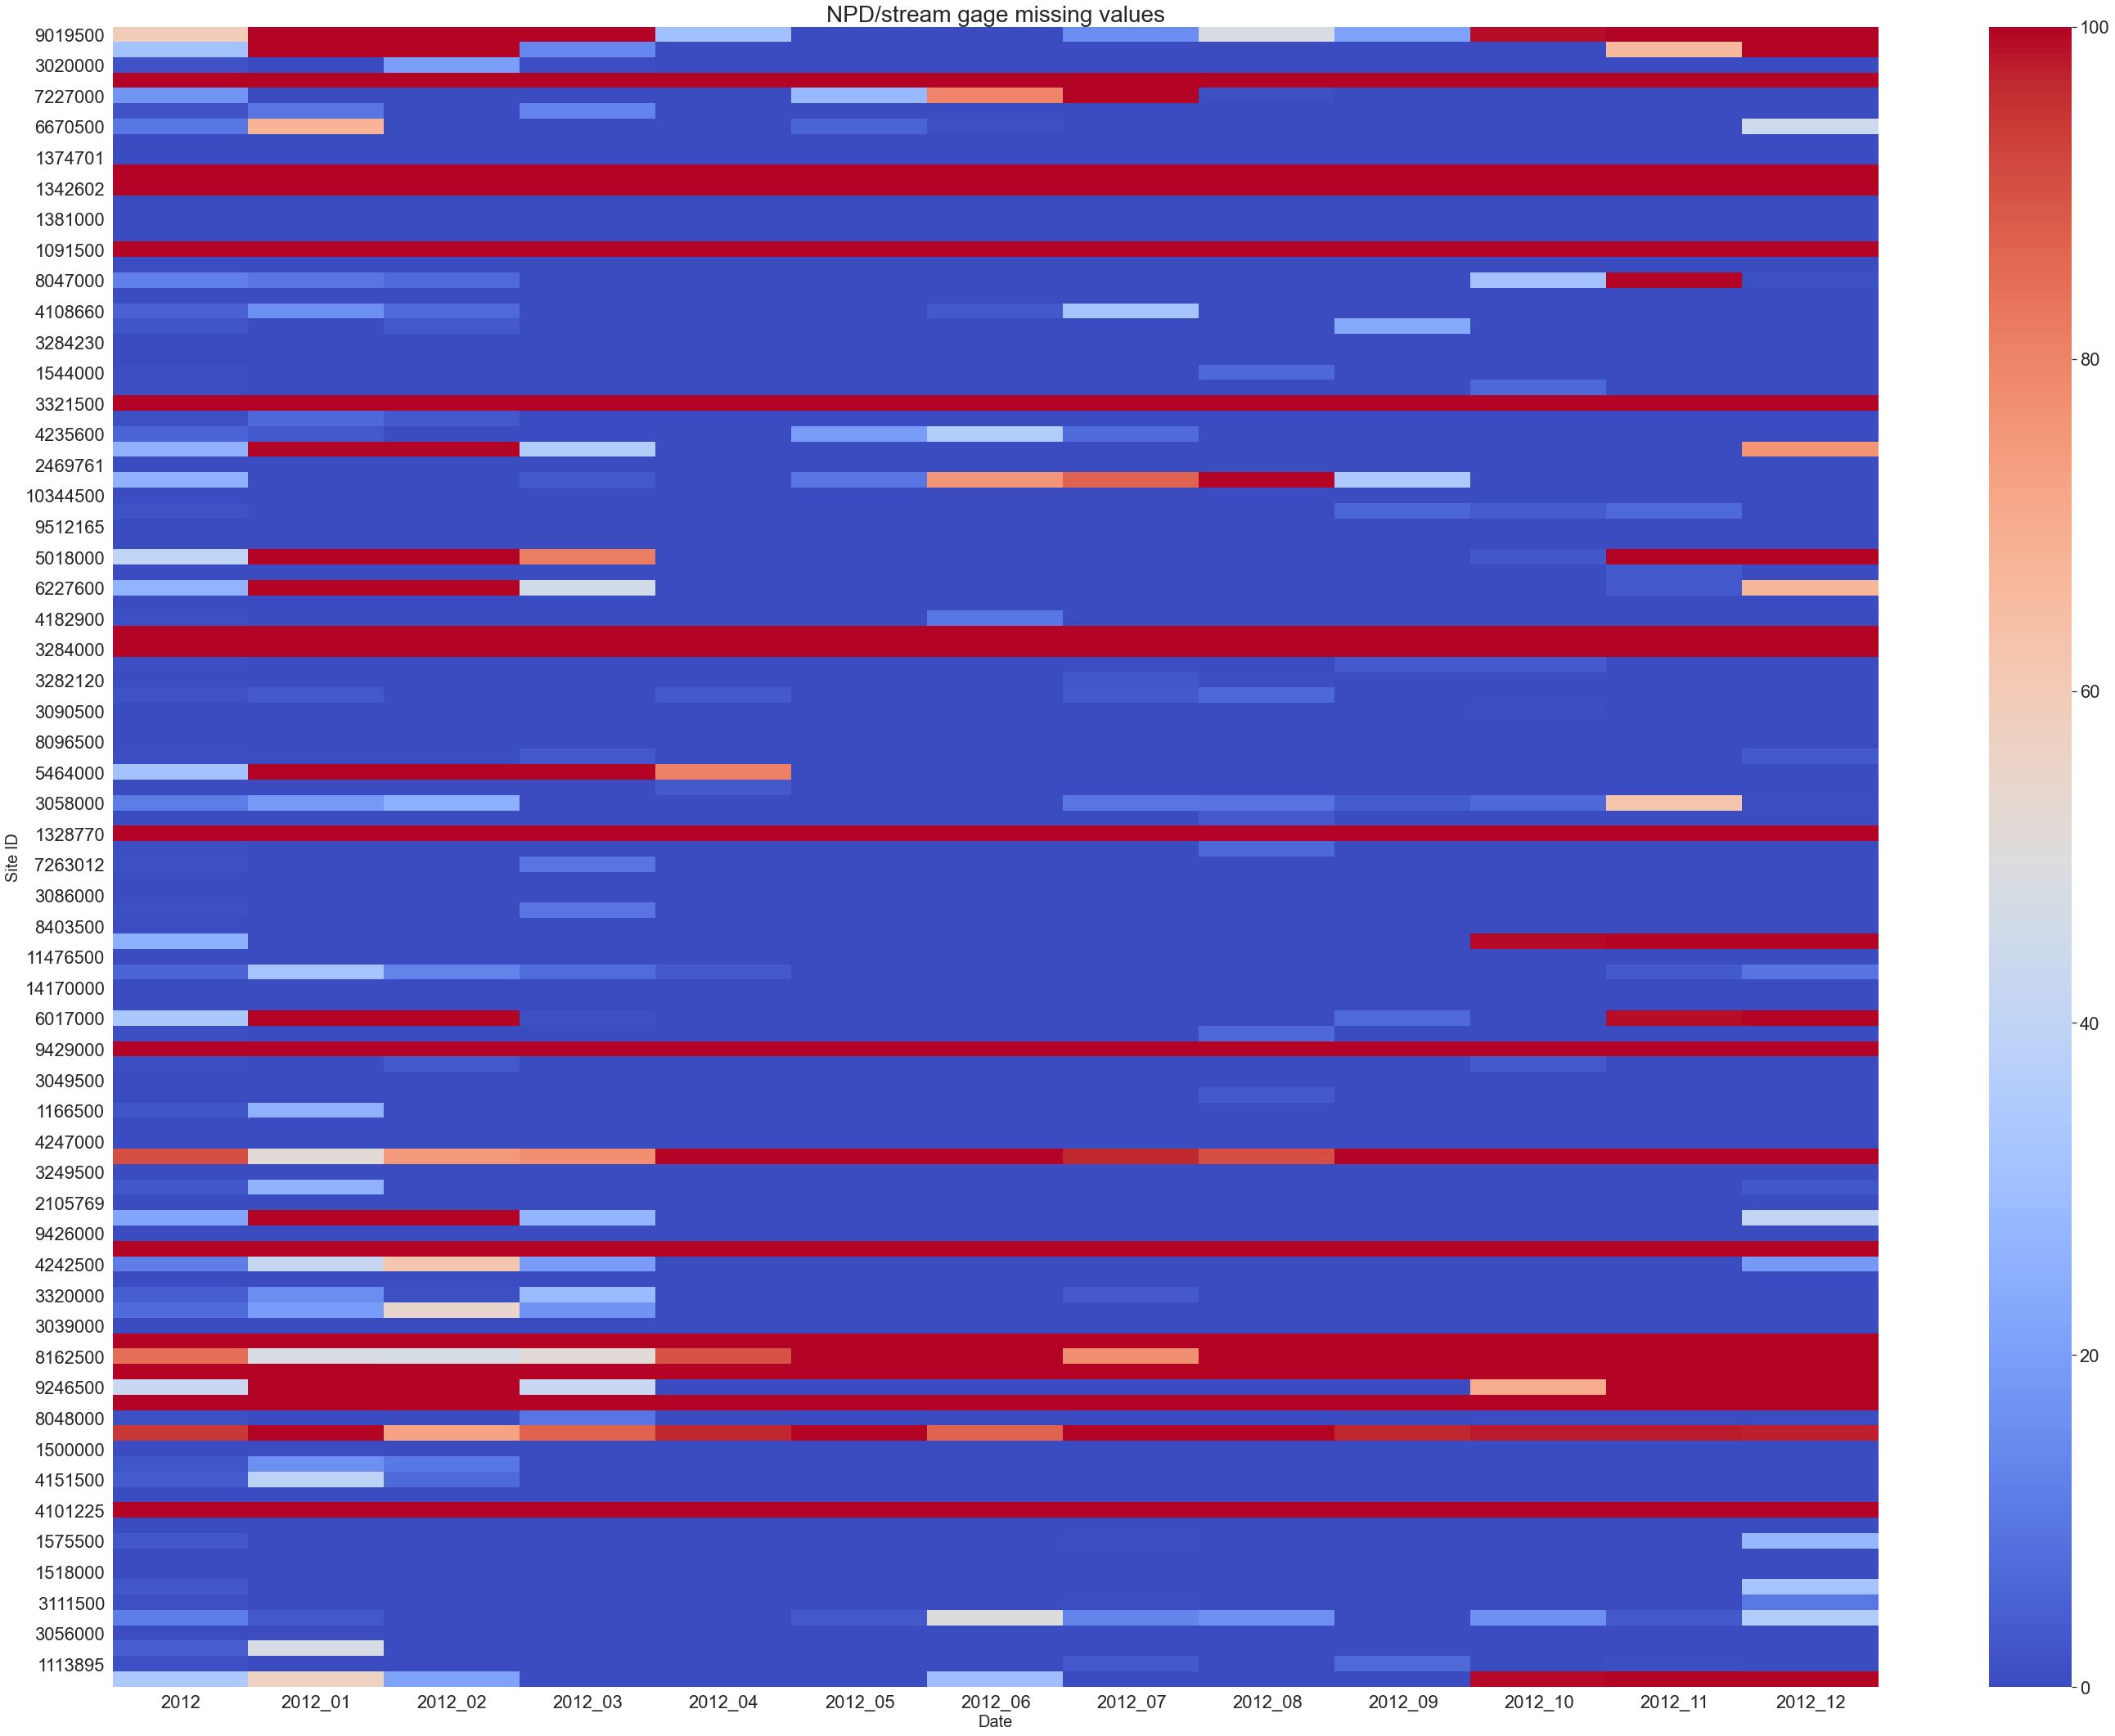

In [24]:
# Plot the nan values as a heatmap.
sns.set(rc={'figure.figsize':(40, 30)}, font_scale=2)
sns.color_palette("coolwarm", as_cmap=True)
ax = sns.heatmap(data=nan_plot_df, vmin=0.0, vmax=100.0, cmap="coolwarm")
ax.set_title("NPD/stream gage missing values", fontsize=28)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel("Site ID", fontsize=20)

fig = ax.get_figure()
plt.tight_layout()
fig.savefig('npd_missing_values_heatmap.jpg')

# Data imputation

1 week or less --> repeat the previous week

1 month or less --> repeat the previous month

More than 1 month --> don't use that year

In [26]:
year = '2012'
pv_wind_id_df = pd.read_csv('query_2021-06-10_pv_wind.csv')
pv_wind_id_df.fillna(0, inplace=True)

pv_wind_id_df.head()

,start,end,lat,lon,name,site_id,json_filename,csv_filename,post_csv_filename,pv_id,wind_id,pv_wind_id_same
0,1/1/00,12/31/20,40.147715,-105.865879,GRANBY,9019500,data/2000_2020_npd/raw/npd_09019500_2000-01-01...,data/2000_2020_npd/raw/npd_09019500_2000-01-01...,/Users/galljf/Box/FlexPower_hydro_assessment/h...,CO01656,CO01656,True
1,1/1/00,12/31/20,36.466670,-91.530000,MAMMOTH SPRINGS DAM 3,7069220,data/2000_2020_npd/raw/npd_07069220_2000-01-01...,data/2000_2020_npd/raw/npd_07069220_2000-01-01...,0,AR01157,AR01157,True
2,1/1/00,12/31/20,35.394714,-106.547531,JEMEZ CANYON DAM,8328950,data/2000_2020_npd/raw/npd_08328950_2000-01-01...,data/2000_2020_npd/raw/npd_08328950_2000-01-01...,/Users/galljf/Box/FlexPower_hydro_assessment/h...,NM00003,NM00003,True
3,1/1/00,12/31/20,41.475038,-79.445464,TIONESTA DAM,3020000,data/2000_2020_npd/raw/npd_03020000_2000-01-01...,data/2000_2020_npd/raw/npd_03020000_2000-01-01...,/Users/galljf/Box/FlexPower_hydro_assessment/h...,PA00110,PA00110,True
4,1/1/00,12/31/20,34.398667,-87.987939,Bear Creek,3592000,data/2000_2020_npd/raw/npd_03592000_2000-01-01...,data/2000_2020_npd/raw/npd_03592000_2000-01-01...,0,AL05903,AL05903,True


In [27]:
print(f"Number of sites without data: {pv_wind_id_df['csv_filename'].loc[pv_wind_id_df['csv_filename']==0].count()}")

Number of sites without data: 0


In [28]:
site = 6890900
pv_wind_id_df['csv_filename'].loc[pv_wind_id_df.site_id == 6890900].values[0]

'data/2000_2020_npd/raw/npd_06890900_2000-01-01_2020-12-31.csv'

In [29]:
hydro_df = pd.read_csv(pv_wind_id_df['csv_filename'].loc[pv_wind_id_df.site_id == site].values[0],parse_dates=True,index_col=0)
hydro_df.drop(columns=['site_id','lat','long'], inplace=True)

<AxesSubplot:xlabel='dateTime'>

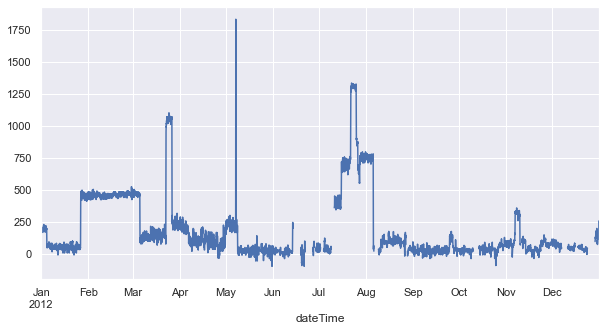

In [36]:
sns.set(rc={'figure.figsize':(10, 5)}, font_scale=1)
hydro_df.loc['2012','discharge(cfs)'].plot()

In [48]:
hydro_df['2012']

,discharge(cfs),norm_discharge_cfs,max_potential_power_mw,actual_power_mw,potential_cap_mw,capacity_factor,estimated_discharge
dateTime,,,,,,,
2012-01-01 00:00:00+00:00,213.00,75.983130,0.0,0.0,3.490849,0.0,0
2012-01-01 01:00:00+00:00,223.00,79.550413,0.0,0.0,3.490849,0.0,0
2012-01-01 02:00:00+00:00,213.00,75.983130,0.0,0.0,3.490849,0.0,0
2012-01-01 03:00:00+00:00,223.00,79.550413,0.0,0.0,3.490849,0.0,0
2012-01-01 04:00:00+00:00,193.00,68.848564,0.0,0.0,3.490849,0.0,0
...,...,...,...,...,...,...,...
2012-12-31 19:00:00+00:00,229.25,81.779965,0.0,0.0,3.490849,0.0,0
2012-12-31 20:00:00+00:00,227.75,81.244872,0.0,0.0,3.490849,0.0,0
2012-12-31 21:00:00+00:00,207.50,74.021124,0.0,0.0,3.490849,0.0,0


In [44]:
def nearest_neighboor_replacement(x, nan_per = 50):
    
    # get the percentage of missing values in group x
    miss_nan = 100 * x['discharge(cfs)'].isnull().sum()/x['discharge(cfs)'].shape[0]
    if miss_nan <= nan_per:
        x['estimated_discharge'] = x['discharge(cfs)'].interpolate(method='nearest')
    else:
        x['estimated_discharge'] = x['discharge(cfs)']
        
    return x

In [45]:
gr = hydro_df['2012'].groupby(pd.Grouper(freq='M')).apply(nearest_neighboor_replacement)

In [46]:
gr

,discharge(cfs),norm_discharge_cfs,max_potential_power_mw,actual_power_mw,potential_cap_mw,capacity_factor,estimated_discharge
dateTime,,,,,,,
2012-01-01 00:00:00+00:00,213.00,75.983130,0.0,0.0,3.490849,0.0,213.00
2012-01-01 01:00:00+00:00,223.00,79.550413,0.0,0.0,3.490849,0.0,223.00
2012-01-01 02:00:00+00:00,213.00,75.983130,0.0,0.0,3.490849,0.0,213.00
2012-01-01 03:00:00+00:00,223.00,79.550413,0.0,0.0,3.490849,0.0,223.00
2012-01-01 04:00:00+00:00,193.00,68.848564,0.0,0.0,3.490849,0.0,193.00
...,...,...,...,...,...,...,...
2012-12-31 19:00:00+00:00,229.25,81.779965,0.0,0.0,3.490849,0.0,229.25
2012-12-31 20:00:00+00:00,227.75,81.244872,0.0,0.0,3.490849,0.0,227.75
2012-12-31 21:00:00+00:00,207.50,74.021124,0.0,0.0,3.490849,0.0,207.50


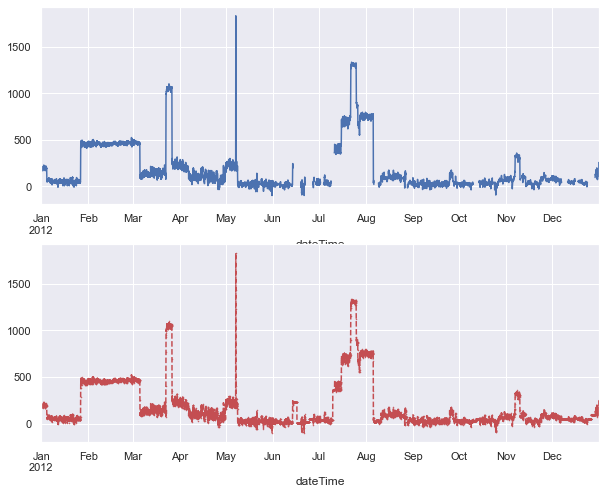

<Figure size 720x576 with 0 Axes>

In [54]:
sns.set(rc={'figure.figsize':(10, 8)}, font_scale=1)
plt.subplot(2, 1, 1)
plt.xlabel('Day of the month')
hydro_df.loc['2012','discharge(cfs)'].plot()

plt.subplot(2, 1, 2)
plt.xlabel('Day of the month')
gr['estimated_discharge'].plot(style='ro--', markersize=0.5)

plt.show()
plt.tight_layout()

<ipython-input-42-1539d21604d2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['estimated_discharge'] = group['discharge(cfs)'].interpolate(method='nearest')
<ipython-input-42-1539d21604d2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['estimated_discharge'] = group['discharge(cfs)'].interpolate(method='nearest')
<ipython-input-42-1539d21604d2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

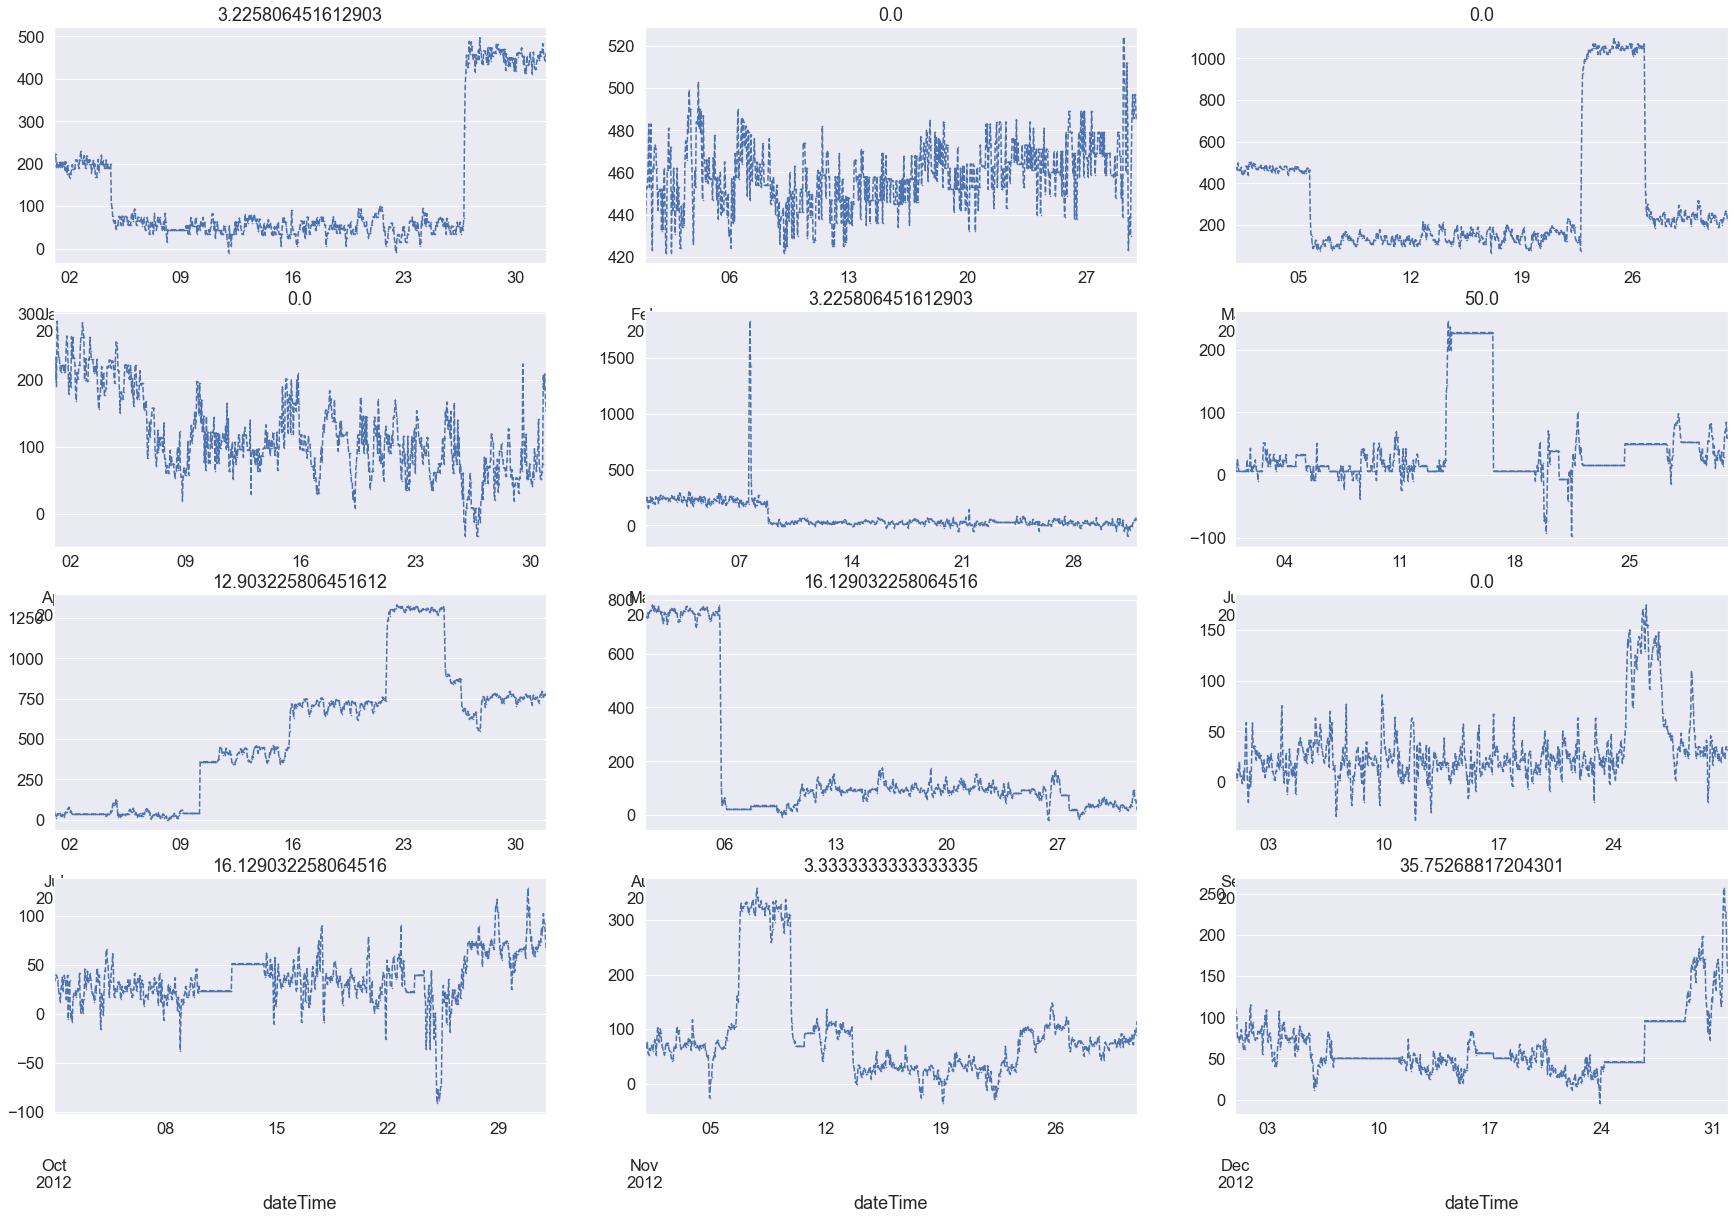

<Figure size 2160x1440 with 0 Axes>

In [42]:
hydro_df['estimated_discharge'] = 0

#Getting the percentage of missing values per week.
gr = hydro_df['2012'].groupby(pd.Grouper(freq='M'))

#  Categorical Data
a = 4  # number of rows
b = 3  # number of columns
x = 1  # initialize plot counter

fig = plt.figure()
sns.set(rc={'figure.figsize':(30,20)}, font_scale=1.5)

for name, group in gr:
    #print(x)
    
    miss_nan = 100 * group['discharge(cfs)'].isnull().sum()/group['discharge(cfs)'].shape[0]
    
    if miss_nan <= 50:
        group['estimated_discharge'] = group['discharge(cfs)'].interpolate(method='nearest')
    else:
        group['estimated_discharge'] = group['discharge(cfs)']
    #print(f"{name} {100 * group['discharge(cfs)'].isnull().sum()/group['discharge(cfs)'].shape[0]}")
    plt.subplot(a, b, x)
    plt.title(f"{miss_nan}")
    plt.xlabel('Day of the month')
    group['estimated_discharge'].plot(style='bo--', markersize=0.5)
    x = x + 1
    
plt.show()
plt.tight_layout()

In [43]:
hydro_df.head()

,discharge(cfs),norm_discharge_cfs,max_potential_power_mw,actual_power_mw,potential_cap_mw,capacity_factor,estimated_discharge
dateTime,,,,,,,
2003-05-05 05:00:00+00:00,111.0,39.596842,0.0,0.0,3.490849,0.0,0
2003-05-05 06:00:00+00:00,124.0,44.234310,0.0,0.0,3.490849,0.0,0
2003-05-05 07:00:00+00:00,124.0,44.234310,0.0,0.0,3.490849,0.0,0
2003-05-05 08:00:00+00:00,85.0,30.321906,0.0,0.0,3.490849,0.0,0
2003-05-05 09:00:00+00:00,84.0,29.965178,0.0,0.0,3.490849,0.0,0


In [19]:
hydro_df['estimated_discharge'] = hydro_df['discharge(cfs)'].interpolate(method='nearest')
hydro_df['estimated_power'] = hydro_df['actual_power_mw'].interpolate(method='nearest')

2012-01-31 00:00:00+00:00 3.225806451612903
2012-02-29 00:00:00+00:00 0.0
2012-03-31 00:00:00+00:00 0.0
2012-04-30 00:00:00+00:00 0.0
2012-05-31 00:00:00+00:00 3.225806451612903
2012-06-30 00:00:00+00:00 50.0
2012-07-31 00:00:00+00:00 12.903225806451612
2012-08-31 00:00:00+00:00 16.129032258064516
2012-09-30 00:00:00+00:00 0.0
2012-10-31 00:00:00+00:00 16.129032258064516
2012-11-30 00:00:00+00:00 3.3333333333333335
2012-12-31 00:00:00+00:00 35.75268817204301


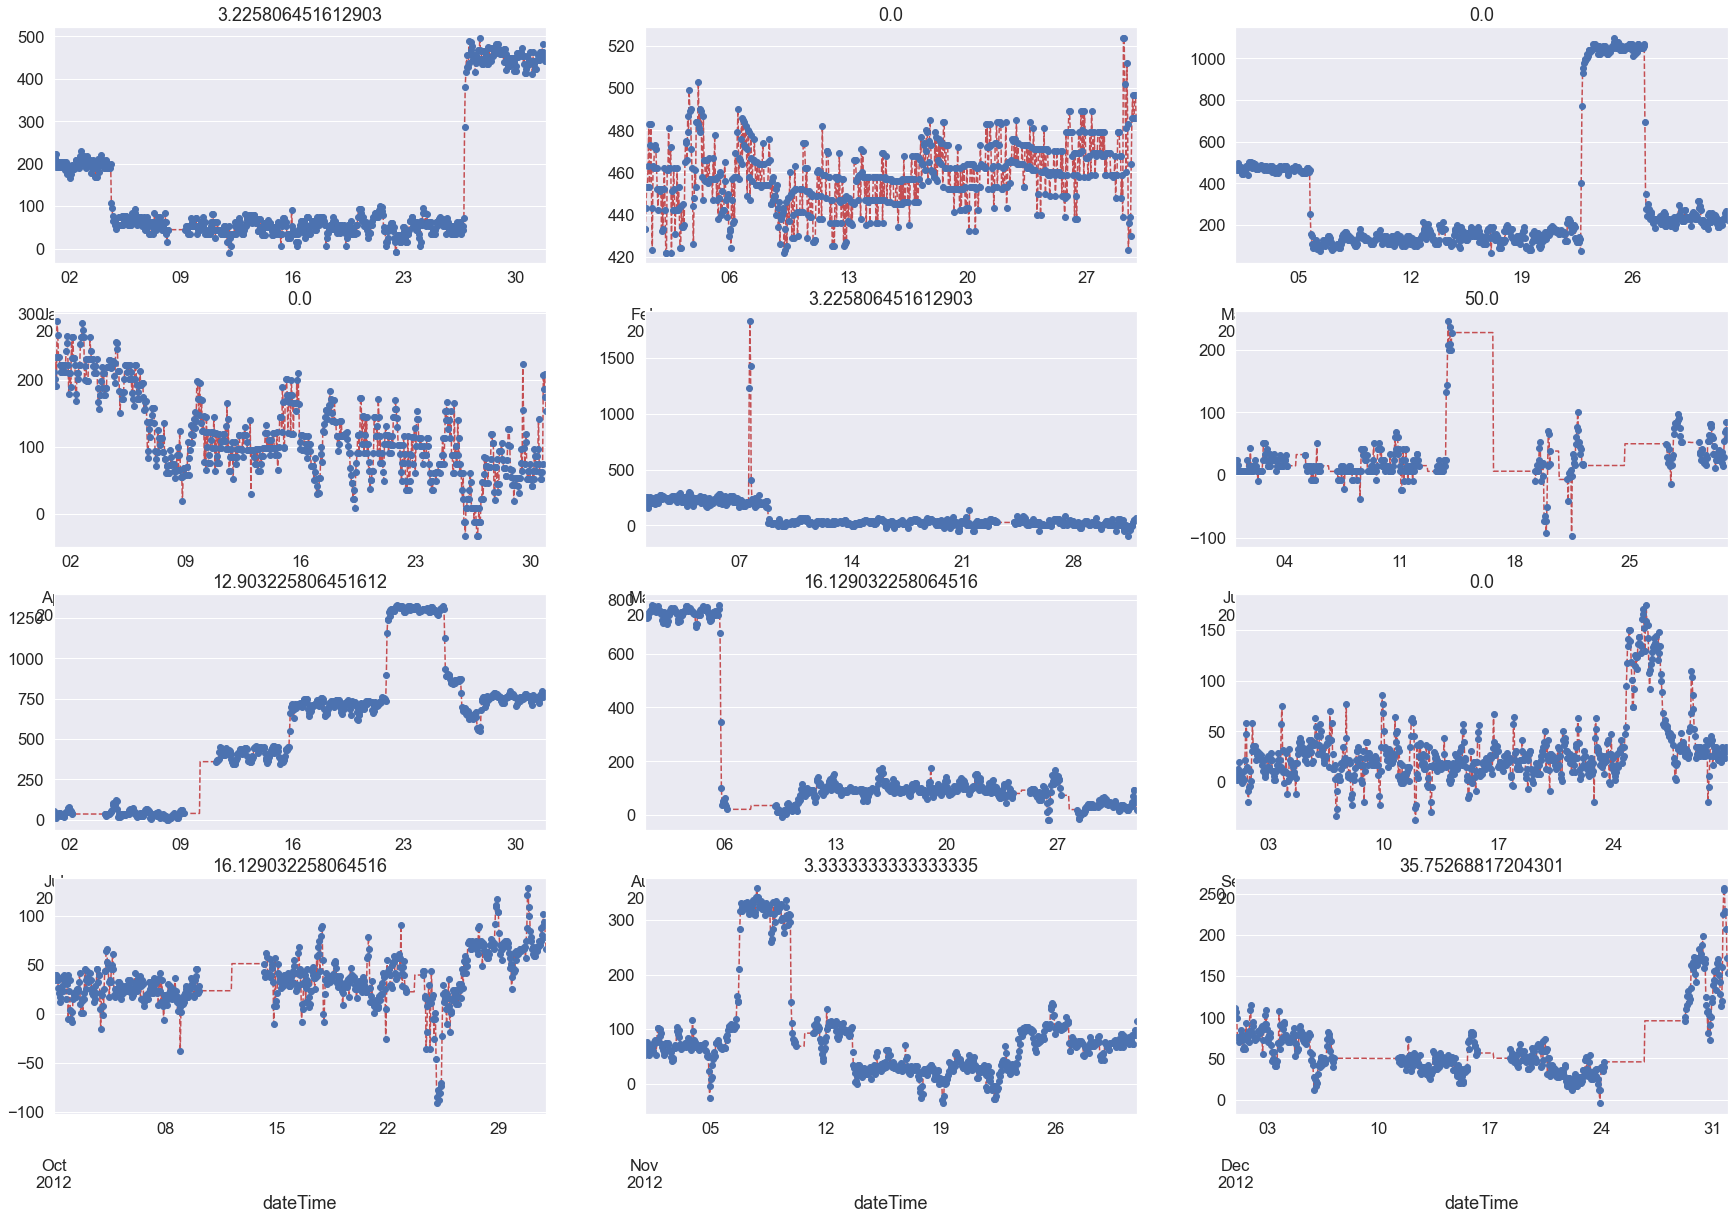

<Figure size 2160x1440 with 0 Axes>

In [25]:
gr = hydro_df['2012'].groupby(pd.Grouper(freq='M'))

#  Categorical Data
a = 4  # number of rows
b = 3  # number of columns
x = 1  # initialize plot counter

fig = plt.figure()
sns.set(rc={'figure.figsize':(30,20)}, font_scale=1.5)

for name, group in gr:
    #print(x)
    print(f"{name} {100 * group['discharge(cfs)'].isnull().sum()/group['discharge(cfs)'].shape[0]}")
    plt.subplot(a, b, x)
    plt.title(f"{100 * group['discharge(cfs)'].isnull().sum()/group['discharge(cfs)'].shape[0]}")
    plt.xlabel('Day of the month')
    group['estimated_discharge'].plot(style='r--')
    group['discharge(cfs)'].plot(style='bo')
    x = x + 1
    
plt.show()
plt.tight_layout()

<AxesSubplot:xlabel='dateTime'>

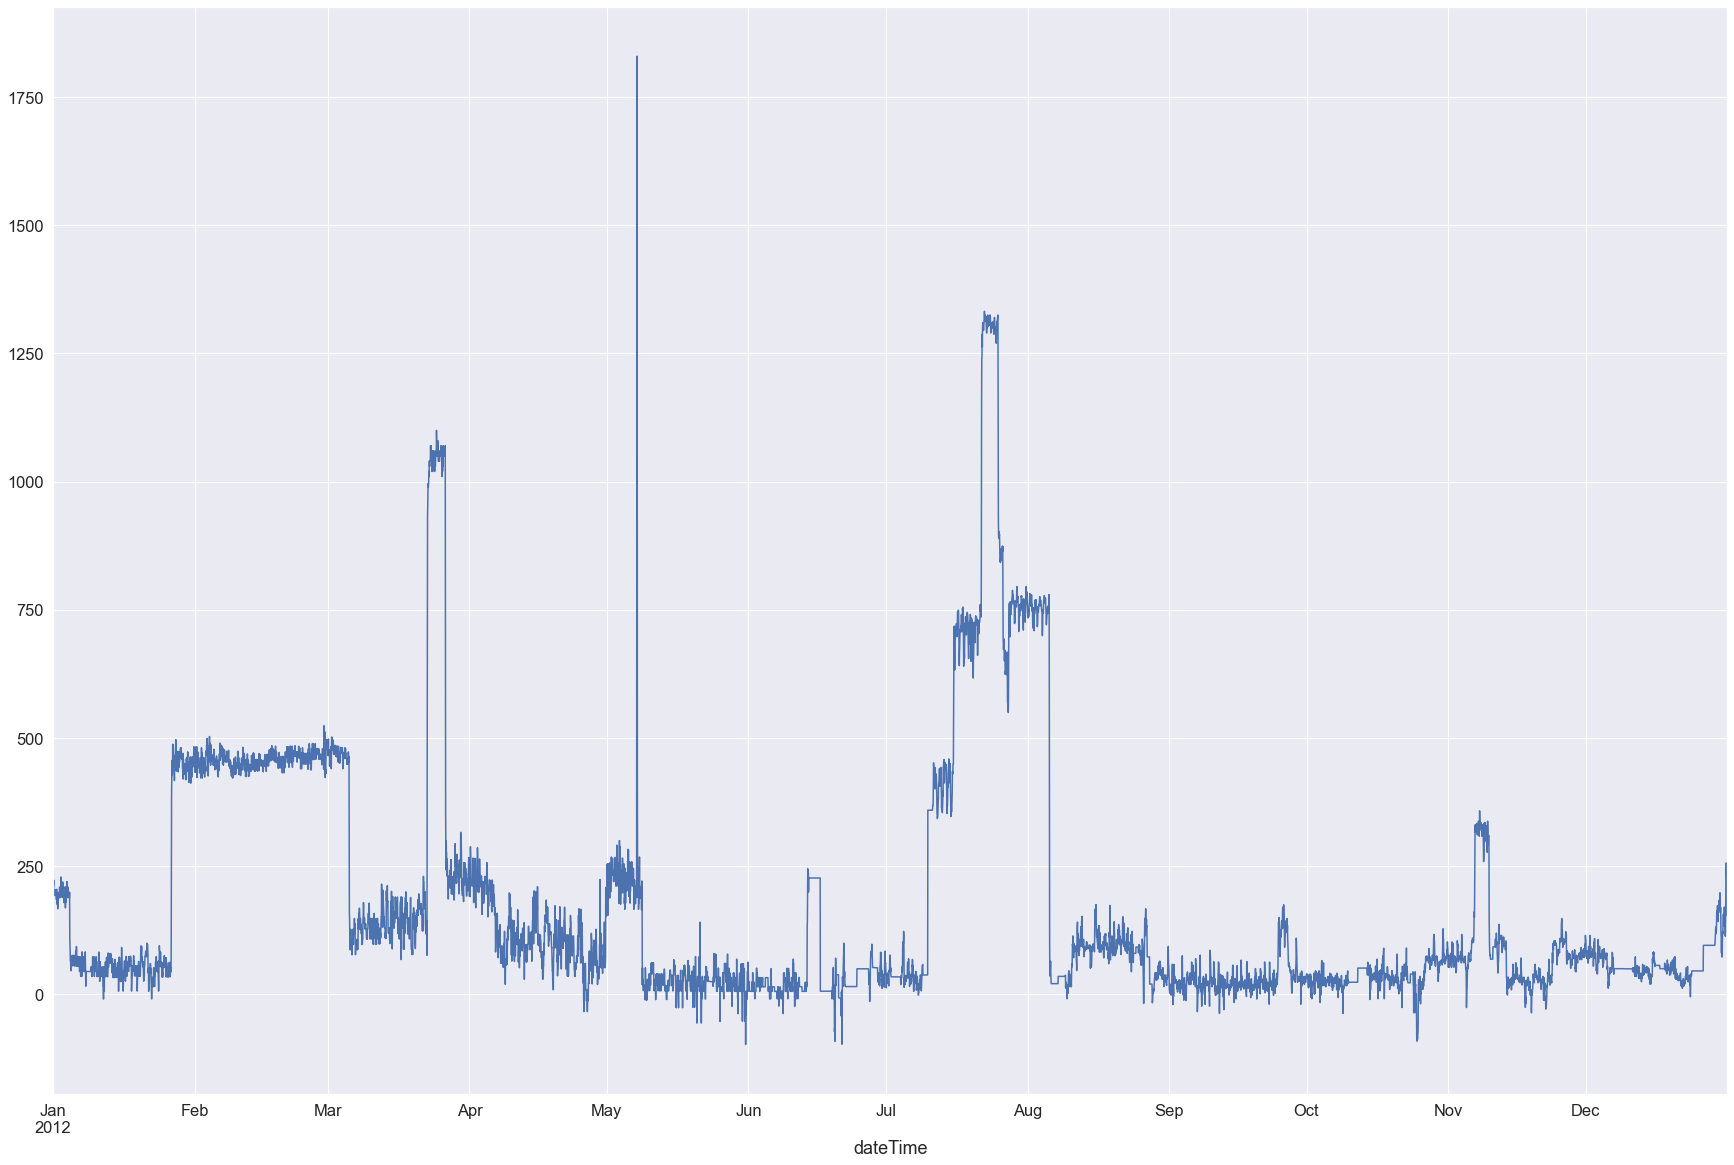

In [21]:
hydro_df.loc['2012','estimated_discharge'].plot()

In [58]:
months = range(1,13)
for month in months:
    if month < 10:
        month = f"0{str(month)}"
    else:
        month = str(month)
    
    print(f"2012_{month}", nan_df[f"2012_{month}"].loc[(nan_df.site_id == site)].values)

2012_01 [3.225806451612903]
2012_02 [0.0]
2012_03 [0.0]
2012_04 [0.0]
2012_05 [3.225806451612903]
2012_06 [50.0]
2012_07 [12.903225806451612]
2012_08 [16.129032258064516]
2012_09 [0.0]
2012_10 [16.129032258064516]
2012_11 [3.3333333333333335]
2012_12 [35.75268817204301]


In [59]:
for idx, row in pv_wind_id_df.iterrows():
    
    if row['post_csv_filename'] == 0:
        print( f"No file for site {row['site_id']} ")
        missing_sites.append(row['site_id'])
        continue
        
    print(f"{idx}. Processing NPD {row['site_id']}, {row['post_csv_filename']}")

    hydro_df = pd.read_csv(row['post_csv_filename'],parse_dates=True,index_col=0)
    print(hydro_df[year])
    
    break

0. Processing NPD 9019500, /Users/galljf/Box/FlexPower_hydro_assessment/hydro_time_series/npd/2000_2020_npd/post/npd_9019500_2007-01-01_2013-12-31.csv
                           discharge(cfs)  site_id  lat  long  \
dateTime                                                        
2012-01-01 00:00:00+00:00             NaN      NaN  NaN   NaN   
2012-01-01 01:00:00+00:00             NaN      NaN  NaN   NaN   
2012-01-01 02:00:00+00:00             NaN      NaN  NaN   NaN   
2012-01-01 03:00:00+00:00             NaN      NaN  NaN   NaN   
2012-01-01 04:00:00+00:00             NaN      NaN  NaN   NaN   
...                                   ...      ...  ...   ...   
2012-12-31 19:00:00+00:00             NaN      NaN  NaN   NaN   
2012-12-31 20:00:00+00:00             NaN      NaN  NaN   NaN   
2012-12-31 21:00:00+00:00             NaN      NaN  NaN   NaN   
2012-12-31 22:00:00+00:00             NaN      NaN  NaN   NaN   
2012-12-31 23:00:00+00:00             NaN      NaN  NaN   NaN   

   